<center><h1>Simulation des prix d'actions </h1></center>


### Importation des bibliothèques
Les bibliothèques nécessaires pour exécuter le code sont importées. Ces bibliothèques sont `numpy` pour les calculs numériques, `yfinance` pour obtenir les données boursières, et `datetime` pour manipuler les dates.


In [1]:
import numpy as np
import yfinance as yf
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Simulation parameters
symbols_to_simulate = [ "AAPL", "AMZN", "META", "NVDA", "TSLA", "ORCL"]
num_simulations = 252
time_steps = 252
diffusion_type = 'GBM'  
global_sim_prices = []
global_closing_prices = []
count = 0
day = 1

### Exploration des données Yahoo Finance

In [2]:
# Téléchargement des données pour le symbole AAPL (Apple Inc.) sur une période donnée
data = yf.download('AAPL', start='2015-01-01', end='2024-01-01')
print(data)
data.isnull().sum()



[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02   27.847500   27.860001   26.837500   27.332500   24.435270   
2015-01-05   27.072500   27.162500   26.352501   26.562500   23.746889   
2015-01-06   26.635000   26.857500   26.157499   26.565001   23.749128   
2015-01-07   26.799999   27.049999   26.674999   26.937500   24.082144   
2015-01-08   27.307501   28.037500   27.174999   27.972500   25.007431   
...                ...         ...         ...         ...         ...   
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.353287   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.803986   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.903839   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.333298   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.284637   

               Volume  
Date         

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2264.0,8.395651e+01,5.597986e+01,2.250000e+01,3.545250e+01,5.404000e+01,1.414450e+02,1.980200e+02
High,2264.0,8.487661e+01,5.661135e+01,2.291750e+01,3.565125e+01,5.474000e+01,1.432750e+02,1.996200e+02
Low,2264.0,8.309209e+01,5.539602e+01,2.236750e+01,3.524375e+01,5.327000e+01,1.392400e+02,1.970000e+02
Close,2264.0,8.402644e+01,5.603470e+01,2.258500e+01,3.543938e+01,5.386875e+01,1.417100e+02,1.981100e+02
Adj Close,2264.0,8.205869e+01,5.644763e+01,2.077216e+01,3.308238e+01,5.163868e+01,1.401517e+02,1.978575e+02
Volume,2264.0,1.237607e+08,6.818458e+07,2.404830e+07,7.831732e+07,1.056556e+08,1.486811e+08,6.488252e+08


On vérifie que notre base de données ne contient pas des valeurs nulles. De plus on constate que toutes les observations sont dans des journées de négociation.Passons maintenant à la représentation graphique de prix de clôture ajusté(Adjusted Closing Price) pour mieux voir les tendances.

En utilisant le prix de clôture ajusté (Adj Close) plutôt que le prix de clôture non ajusté (Close), nous obtenons une représentation plus précise de la performance historique d'une action, en tenant compte des événements tels que les dividendes, les fusions, les scissions et autres ajustements. Cela permet une analyse plus précise et une meilleure prise de décision dans le domaine financier.

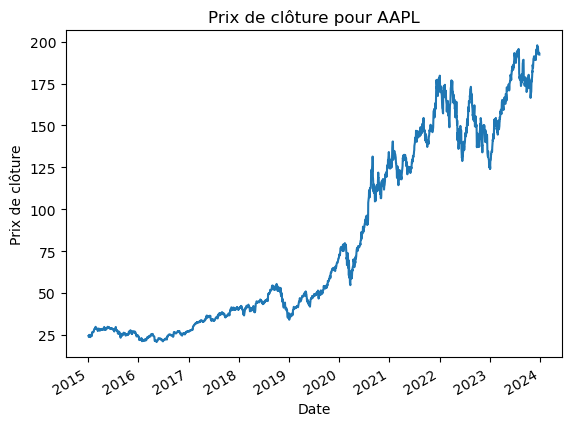

In [4]:
# Tracé des prix de clôture au fil du temps pour visualiser les tendances
data['Adj Close'].plot(title='Prix de clôture pour AAPL')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.show()

In [5]:
# Calcul de la moyenne des prix de clôture pour évaluer la tendance générale
mu = data['Adj Close'].mean()

# Calcul de l'écart-type des prix de clôture pour évaluer la volatilité
sigma = data['Adj Close'].std()

# Affichage de la moyenne et de l'écart-type des prix de clôture
print("Moyenne des prix de clôture :", mu)
print("Écart-type des prix de clôture :", sigma)

Moyenne des prix de clôture : 82.05868719744598
Écart-type des prix de clôture : 56.44762504628913


In [6]:
from scipy.stats import skewtest
import numpy as np

# Effectuer le test de skewness
statistic, p_value = skewtest(data['Adj Close'])

# Afficher les résultats
print("Test Statistic:", statistic)
print("p-value:", p_value)

# Interprétation des résultats
alpha = 0.05
if p_value < alpha:
    print("Les données ne suivent pas une distribution normale (rejeter l'hypothèse nulle)")
else:
    print("Les données suivent une distribution normale (ne pas rejeter l'hypothèse nulle)")


Test Statistic: 9.906177165042271
p-value: 3.913340517910642e-23
Les données ne suivent pas une distribution normale (rejeter l'hypothèse nulle)


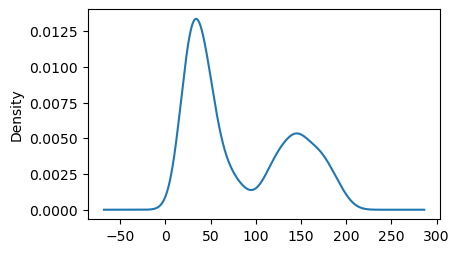

In [7]:
data['Adj Close'].plot(kind='density', subplots=True, layout=(2,2), sharex=False, figsize=(10, 6))
plt.show()

Appliquer une transformation logarithmique aux données est une technique courante pour réduire ou atténuer la skewness (asymétrie) dans la distribution des données.Il est important de noter que l'application d'une transformation logarithmique peut parfois ne pas être appropriée, en particulier si les données contiennent des valeurs négatives ou des zéros. Dans de tels cas, d'autres transformations telles que la transformation Box-Cox peuvent être préférées.Dans notre cas on n'a pas des prix négatifs mais on peut vérifier pour des prix nuls.

In [8]:
num_negative = np.sum(data['Adj Close'] == 0)

percentage_negative = (num_negative / len(data['Adj Close'])) * 100

print("Pourcentage d'observations négatives :", percentage_negative)

Pourcentage d'observations négatives : 0.0


Donc on peut faire la transformation sans problémes.

In [9]:
log = np.log(1 + data['Adj Close'].pct_change())
log = log.dropna() #pour enlever les valeurs nulles resultantes de la transformation.

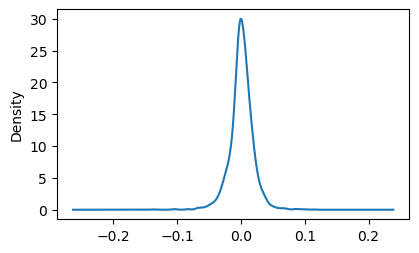

In [10]:
log.plot(kind='density', subplots=True, layout=(2,2), sharex=False, figsize=(10, 6))
plt.show()

On constate que la distribution est plus proche que celle de la loi normale maintenant.

In [11]:
num_simulations=252
time_steps = 252
sim_prices = np.zeros((num_simulations, time_steps))
# Set the initial price for all simulations
initial_price = log.iloc[-1]

sim_prices[:, 0] = initial_price
# Set the time step
dt = 1 / time_steps

for i in range(1, time_steps):
    # Generate random numbers for each simulation
    rand = np.random.normal(0, 1, num_simulations)
    # Use GBM to calculate the next price for each simulation
    sim_prices[:, i] = sim_prices[:, i - 1] * np.exp(
        (mu - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rand)


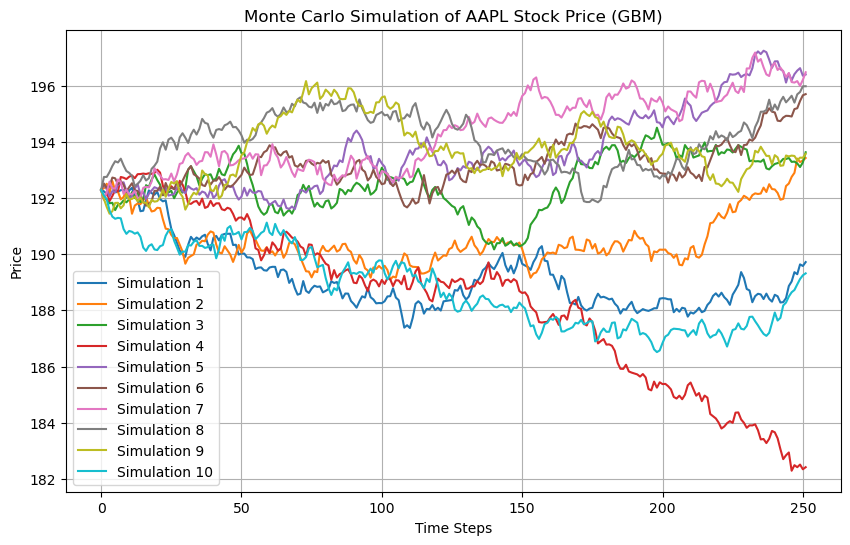

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
initial_price = data['Adj Close'].iloc[-1]  # Initial price is the last observed price
time_steps = 252  # Trading days in a year
num_simulations = 10  # Number of simulations

# Calculate drift and volatility from historical data
log_returns = np.log(1 + data['Adj Close'].pct_change())
log_returns = log_returns.dropna()  # Remove NaN values resulting from the transformation
mu = log_returns.mean()
sigma = log_returns.std()

# Create an array to store the simulated prices
sim_prices = np.zeros((num_simulations, time_steps))
# Set the initial price for all simulations
sim_prices[:, 0] = initial_price
# Set the time step
dt = 1 / time_steps

# Simulate price evolution using GBM
for i in range(1, time_steps):
    # Generate random numbers for each simulation
    rand = np.random.normal(0, 1, num_simulations)
    # Use GBM to calculate the next price for each simulation
    sim_prices[:, i] = sim_prices[:, i - 1] * np.exp(
        (mu - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rand)

# Plot the simulated price paths
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(sim_prices[i], label=f'Simulation {i+1}')
plt.title('Monte Carlo Simulation of AAPL Stock Price (GBM)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



Pensons maintenant à généraliser cette démarche.Pour cela il faut incorporer les étapes précédentes dans des fonctions .

### Paramètres de simulation
1. `symbols_to_simulate`: Une liste des symboles boursiers à simuler.
2. `num_simulations`: Le nombre de simulations à effectuer.
3. `time_steps`: Le nombre d'étapes temporelles dans chaque simulation.



In [22]:
# Simulation parameters
symbols_to_simulate = [ "AAPL", "AMZN", "META", "NVDA", "TSLA", "ORCL"]
num_simulations = 10000
time_steps = 252
diffusion_type = 'GBM'  
global_sim_prices = []
global_closing_prices = []
count = 0
day = 1

### Fonction `get_stock_data`
Cette fonction récupère les données boursières pour un symbole donné à partir d'une date de début spécifiée jusqu'à la date actuelle. Elle calcule ensuite le rendement logarithmique quotidien, la moyenne du rendement (mu), l'écart-type (sigma), et le prix de clôture.


In [14]:
# Retreive stock data from desired start date until last available
def get_stock_data(ticker, start_date):
    today = dt.date.today()
    end_date = today.strftime("%Y-%m-%d")
    try:
        # Get the stock data
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        stock_data.head()
    except:
        return "No data found, please try again later"
    # Calculate the daily logarithmic returns
    returns = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))
    returns = returns.dropna()
    # Calculate the mean rate of return (mu)
    mu = returns.mean()
    # Calculate the volatility (sigma)
    sigma = returns.std()
    # Get the closing price
    closing_price = stock_data['Adj Close'].iloc[-1]
    return mu, sigma, closing_price

### Fonction `monte_carlo_simulation`
Cette fonction réalise la simulation de Monte Carlo pour le Mouvement Brownien Géométrique (GBM) . Elle prend en compte les paramètres suivants :

- `num_simulations`: Le nombre de simulations à effectuer.
- `time_steps`: Le nombre d'étapes temporelles dans chaque simulation.
- `mu`: La moyenne des rendements logarithmiques.
- `sigma`: L'écart-type des rendements logarithmiques.
- `initial_price`: Le prix initial.


Elle génère un tableau de prix simulés en fonction des paramètres passés. Elle utilise la formule classique du GBM pour calculer les prix. Les prix simulés sont stockés dans `global_sim_prices`.


In [15]:
# MonteCarlo simulation function for Geometric Brownian Motion or Jump Diffusion
def monte_carlo_simulation(mu, sigma, initial_price):
    global global_sim_prices
    # Create an array to store the simulated prices
    sim_prices = np.zeros((num_simulations, time_steps))
    # Set the initial price for all simulations
    sim_prices[:, 0] = initial_price
    # Set the time step
    dt = 1 / time_steps
    
    for i in range(1, time_steps):
        # Generate random numbers for each simulation
        rand = np.random.normal(0, 1, num_simulations)
        # Use GBM to calculate the next price for each simulation
        sim_prices[:, i] = sim_prices[:, i - 1] * np.exp(
            (mu - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rand)


    global_sim_prices.append(np.mean(sim_prices, axis=0))

### Fonction `simulation`
Cette fonction gère la simulation des prix des actions pour chaque jour et chaque symbole dans `symbols_to_simulate`. Elle itère sur les jours de simulation jusqu'à ce qu'un an (365 jours) soit écoulé. Pendant chaque itération, elle obtient les données de prix initiales à partir de la date de début spécifiée (1er janvier 2000 dans ce cas), puis elle lance la simulation de Monte Carlo en utilisant la fonction `monte_carlo_simulation`. Les prix simulés sont comparés aux prix de clôture réels pour chaque jour, et les variations sont calculées et stockées. Ensuite, les résultats sont imprimés, montrant le jour de la simulation, le symbole boursier, le prix simulé, le prix de clôture réel et la variation entre les deux.

Pendant la première itération (jour 0), les prix de clôture réels sont obtenus et stockés dans `global_closing_prices`, puis la simulation de Monte Carlo est lancée pour estimer les prix simulés.

Les jours suivants, les prix simulés sont extraits de `global_sim_prices` pour chaque symbole et comparés aux prix de clôture réels pour chaque symbole, afin de calculer les variations.

Les résultats sont affichés pour chaque jour de simulation et pour chaque symbole, fournissant ainsi un aperçu des performances de la simulation par rapport aux prix réels.

Une fois toutes les simulations terminées, la fonction incrémente le jour de simulation et le compteur de jours, et continue jusqu'à ce que 365 jours soient atteints.


In [16]:
def simulation():
    global count
    global symbols_to_simulate
    global day
    global global_sim_prices
    global global_closing_prices
    while count<=252:
        simulated_prices = []
        variations = []  # Store the differences between simulated and closing prices
        if count == 0:
            for i in range(len(symbols_to_simulate)):
                start_date = '2000-01-01'
                mu, sigma, closing_price = get_stock_data(symbols_to_simulate[i], start_date)
                global_closing_prices.append(closing_price)
                monte_carlo_simulation(mu, sigma, closing_price)
                simulated_price = round(global_sim_prices[i][count], 12)
                simulated_prices.append(simulated_price)
                variation = round(simulated_price - closing_price, 12)
                variations.append(variation)
                print("Day:", day)
                print("Symbol:", symbols_to_simulate[i])
                print("Simulated Price:", simulated_price)
                print("Closing Price:", closing_price)
                print("Variation:", variation)
                print("")

        else:
            for i in range(len(symbols_to_simulate)):
                if count < len(global_sim_prices[i]):
                    simulated_price = round(global_sim_prices[i][count], 12)
                    simulated_prices.append(simulated_price)
                    variation = round(simulated_price - global_closing_prices[i], 12)
                    variations.append(variation)
                    print("Day:", day)
                    print("Symbol:", symbols_to_simulate[i])
                    print("Simulated Price:", simulated_price)
                    print("Closing Price:", global_closing_prices[i])
                    print("Variation:", variation)
                    print("")
                else:
                    simulated_prices.append(0)  # Placeholder value if the index is out of bounds
                    variations.append(0)  # Placeholder value for variation if the index is out of bounds
        
        day += 1
        count += 1


In [17]:
import datetime as dt
simulation()

[*********************100%%**********************]  1 of 1 completed


Day: 1
Symbol: AAPL
Simulated Price: 170.330001831055
Closing Price: 170.3300018310547
Variation: 0.0



[*********************100%%**********************]  1 of 1 completed


Day: 1
Symbol: AMZN
Simulated Price: 175.0
Closing Price: 175.0
Variation: 0.0



[*********************100%%**********************]  1 of 1 completed


Day: 1
Symbol: META
Simulated Price: 430.170013427734
Closing Price: 430.1700134277344
Variation: -0.0



[*********************100%%**********************]  1 of 1 completed


Day: 1
Symbol: NVDA
Simulated Price: 864.02001953125
Closing Price: 864.02001953125
Variation: 0.0



[*********************100%%**********************]  1 of 1 completed


Day: 1
Symbol: TSLA
Simulated Price: 183.279998779297
Closing Price: 183.27999877929688
Variation: 0.0




[*********************100%%**********************]  1 of 1 completed

Day: 1
Symbol: ORCL
Simulated Price: 113.75
Closing Price: 113.75
Variation: 0.0

Day: 2
Symbol: AAPL
Simulated Price: 170.328638061546
Closing Price: 170.3300018310547
Variation: -0.001363769509

Day: 2
Symbol: AMZN
Simulated Price: 174.999558985264
Closing Price: 175.0
Variation: -0.000441014736

Day: 2
Symbol: META
Simulated Price: 430.16572050095
Closing Price: 430.1700134277344
Variation: -0.004292926784

Day: 2
Symbol: NVDA
Simulated Price: 864.044437136573
Closing Price: 864.02001953125
Variation: 0.024417605323

Day: 2
Symbol: TSLA
Simulated Price: 183.281782366892
Closing Price: 183.27999877929688
Variation: 0.001783587595

Day: 2
Symbol: ORCL
Simulated Price: 113.750128785946
Closing Price: 113.75
Variation: 0.000128785946

Day: 3
Symbol: AAPL
Simulated Price: 170.332745138049
Closing Price: 170.3300018310547
Variation: 0.002743306994

Day: 3
Symbol: AMZN
Simulated Price: 175.001976127724
Closing Price: 175.0
Variation: 0.001976127724

Day: 3
Symbol: META
Simulated Price: 430

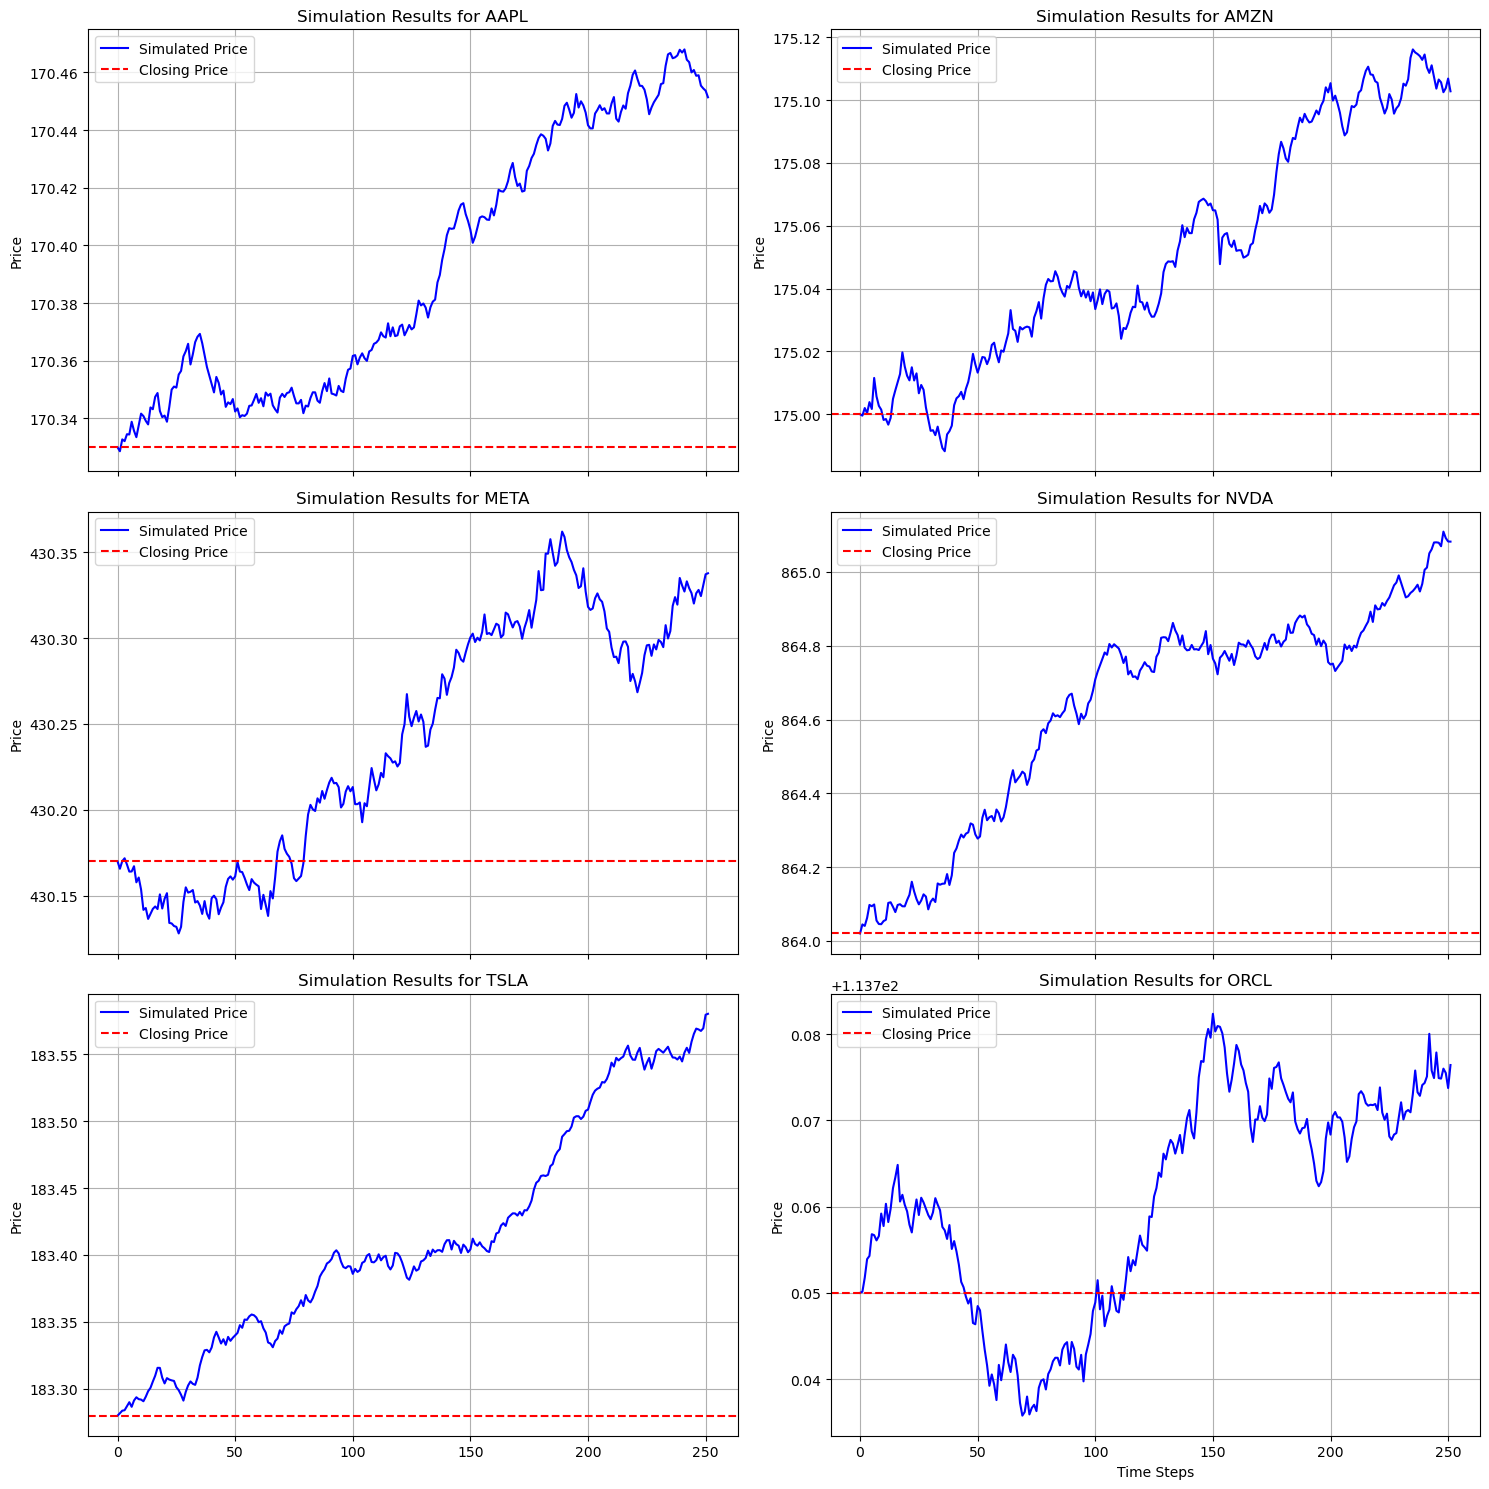

In [18]:
import matplotlib.pyplot as plt

# Plotting simulation results
num_rows = 3
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15), sharex=True)

for i, symbol in enumerate(symbols_to_simulate):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].plot(global_sim_prices[i], label='Simulated Price', color='blue')
    axes[row, col].axhline(y=global_closing_prices[i], linestyle='--', color='red', label='Closing Price')
    axes[row, col].set_title(f'Simulation Results for {symbol}')
    axes[row, col].set_ylabel('Price')
    axes[row, col].legend()
    axes[row, col].grid(True)

plt.xlabel('Time Steps')
plt.tight_layout()
plt.show()